In [30]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import uncertainties.unumpy as unp
import matplotlib as mpl
from scipy.special import erfc
from lmfit import Model
from datetime import datetime
from uncertainties import ufloat
from matplotlib import font_manager
from scipy.stats import chi2
from scipy.optimize import curve_fit

# Math Functions

In [31]:
def rect(x, b0, b1, mean):
    '''
    Descripción
    -----------
    Cálculo de una función lineal a partir de unos parámetros dados.
    
    Parámetros
    ----------
    x (float or np.array): Variable dependiente
    b0 (float): Corte con el eje y
    b1 (float): Pendiente
    mean (float): Centroide

    Retorna
    -------
    Arreglo (o valor individual) de la función evaluada en x
    '''
    return b0 + b1*(mean-x) #Background

##############################################################################

#Función Error Complemento
def rerfc(x, b0, b1, mean, stdev):
    '''
    Descripción
    -----------
    Función que calcula el fondo de un ajuste gaussiano describiendo la
    función error complemento adaptada a los parámetros de la gaussiana.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.
    
    Retorna
    -------
    Los valores de la función error complemento adaptada a la gaussiana del ajuste.
    '''
    return b0 + (b1/2)*erfc((x-mean)/(np.sqrt(2)*stdev)) #Background

##############################################################################

#Función Gaussiana con Fondo Lineal
def gaussian_rect(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, mean) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, mean, stdev) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Error by Poisson's Distribution
def Poisson_Incertidumbre(y_values):
    '''
    Descripción
    -----------
    Se calcula la incertidumbre de los valores de las cuentas/canal de un espectro a
    partir del error de acuerdo a la distribución de Poisson.

    Parámetros
    ----------
    y_values (np.array): Valores de cuentas/canal en un espectro.

    Retorna:
    --------
    sigma_y (np.array): Valores de la incertidumbre asignada a los valores de las 
                        cuentas/canal de un espectro
    '''
    sigma_y = np.sqrt(np.abs(y_values))
    for i in range(len(y_values)):
        if y_values[i] == 0:
            sigma_y[i] = 1
    return sigma_y


# Formato grafico

In [32]:
#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Configurar la notación científica
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels, edgecolor='1', framealpha=0.5, prop=font)


# Main function

In [35]:
def load_spectrum_with_uncertainty(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    channels = data[:, 0]
    counts = data[:, 1]
    uncertainties = Poisson_Incertidumbre(counts)
    spectrum_with_unc = unp.uarray(counts, uncertainties)
    return channels, spectrum_with_unc



def get_peak_ranges_with_uncertainty_and_corrected_data(raw_data_path, background_path, method, num_peaks, save_path=None):
    """
    Carga datos crudos y de fondo, aplica propagación de incertidumbre y 
    muestra un gráfico del espectro corregido. Luego solicita los rangos
    (mínimo y máximo) de los picos al usuario.

    Parameters:
    - raw_data_path (str): Ruta al archivo de datos crudos
    - background_path (str): Ruta al archivo de fondo
    - method (int): Método a usar (1 o 2)
    - num_peaks (int): Número de picos a registrar
    - save_path (str): Ruta opcional para guardar el gráfico

    Returns:
    - peaks_info (list of dicts): Información de los rangos de los picos
    - corrected_data (array of ufloats): Datos corregidos
    - channels (array): Canales correspondientes a corrected_data
    """

    if method not in [1, 2]:
        raise ValueError("⚠️ Method must be either 1 or 2.")

    print(f"\n➡️ Cargando datos con incertidumbre de Poisson...")
    channels_raw, raw_with_unc = load_spectrum_with_uncertainty(raw_data_path)
    channels_back, background_with_unc = load_spectrum_with_uncertainty(background_path)

    if len(raw_with_unc) != len(background_with_unc):
        raise ValueError("⚠️ Raw data and background must be the same length.")

    corrected_data = raw_with_unc - background_with_unc
    corrected_counts = unp.nominal_values(corrected_data)

    print("✅ Datos corregidos calculados con propagación de incertidumbre.")

    # 📈 Graficar antes de pedir rangos
    plt.figure(figsize=(10, 5))
    plt.step(channels_raw, corrected_counts, color='green', label="Espectro corregido", where='mid')
    plt.xlabel(r'Canal')
    plt.ylabel(r'$I_{\gamma}$ [cuentas/canal]')
    plt.title("Espectro corregido (sin fondo)")
   # plt.xlim([0, max(channels_raw)])
    plt.xlim([0, 300])
    plt.tight_layout()
    formato_grafico()
    plt.grid()
    plt.legend()

    if save_path is not None:
        filename = "espectro_corregido.png"
        full_path = os.path.join(save_path, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"💾 Gráfico guardado en: {full_path}")

    plt.show()

    # 🧾 Pedir rangos de picos
    peaks_info = []
    print(f"\n🧾 Ingrese los rangos de canales para {num_peaks} picos:")
    for i in range(num_peaks):
        print(f"\n--- Pico #{i+1} ---")
        while True:
            try:
                min_range = float(input("Canal mínimo del pico: "))
                max_range = float(input("Canal máximo del pico: "))

                if not (min_range < max_range):
                    print("⚠️ El canal mínimo debe ser menor que el máximo.")
                    continue

                peaks_info.append({
                    'min_range': min_range,
                    'max_range': max_range
                })
                break
            except ValueError:
                print("❌ Entrada inválida. Use números decimales.")

    print("\n✅ Rangos de picos ingresados correctamente.")
    return peaks_info, corrected_data, channels_raw


# Main block


➡️ Cargando datos con incertidumbre de Poisson...
✅ Datos corregidos calculados con propagación de incertidumbre.


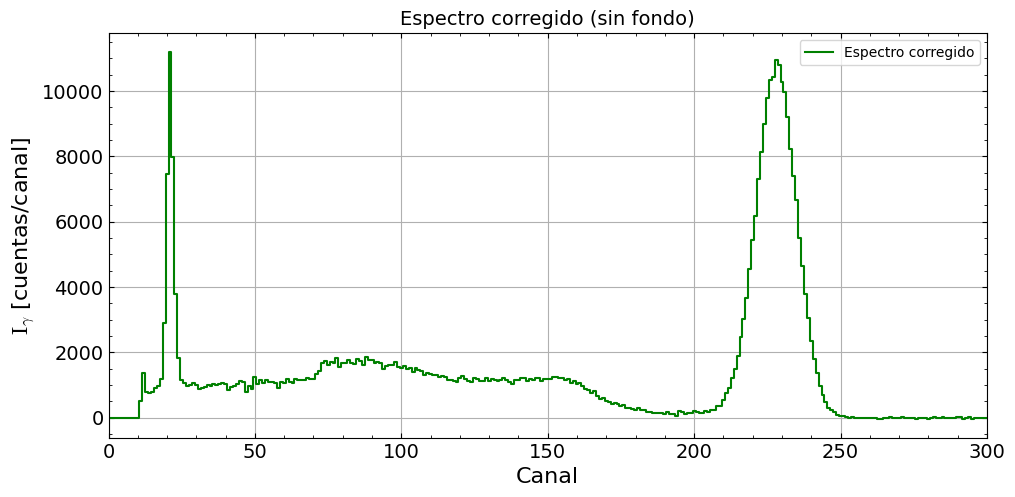


🧾 Ingrese los rangos de canales para 2 picos:

--- Pico #1 ---


Canal mínimo del pico:  15
Canal máximo del pico:  40



--- Pico #2 ---


Canal mínimo del pico:  205
Canal máximo del pico:  250



✅ Rangos de picos ingresados correctamente.


In [36]:
peaks, corrected, channels = get_peak_ranges_with_uncertainty_and_corrected_data(
    "Informe2/Data/NaI_137Cs_600s.dat", 
    "Informe2/Data/NaI_Fondo_600s.dat", 
    method=1, 
    num_peaks=2
)
